In [2]:
import numpy as np
import PIL.Image
import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])
DATASET_PATH = "./dataset_rot/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
CLASSES = next(os.walk(DATASET_PATH))[1]

print(DATASET_PATH)
print(CLASSES)

: 

In [ ]:
def load_data():
    # Récupération des fichiers
    files = glob.glob(f"{DATASET_PATH}/**/*.jpg", recursive = True)

    # Initialise les structures de données
    x = np.zeros((len(files), *RESIZED_SIZE_PIL))
    y = np.zeros((len(files), 1))

    # print(f"x.shape = {x.shape}")

    for i, path in enumerate(files):
        # Lecture de l'image
        img = PIL.Image.open(path)

        # print(f"img.size = {img.size}")

        # Redimensionnement de l'image
        img = img.resize(RESIZED_SIZE[:-1], PIL.Image.ANTIALIAS)

        # print(f"img.size = {img.size}")

        test = np.asarray(img)

        # print(f"test.shape = {test.shape}")

        # Remplissage de la variable x
        x[i] = test

        # On récupère l'index dans le path
        class_label = path.split("/")[-2]

        # On récupère le numéro de la classe à partir du string
        class_label = CLASSES.index(class_label)
        
        # Remplissage de la variable y
        y[i] = class_label

    return x, y

: 

In [ ]:
x, y = load_data()
x = x / 255

: 

In [ ]:
# Randomisation des indices et affichage de 9 images alétoires de la base d'apprentissage
indices = np.arange(x.shape[0])
np.random.shuffle(indices)

plt.figure(figsize=(12, 6))

for i in range(0, 3*3):
    plt.subplot(3, 3, i+1)
    plt.title(CLASSES[int(y[indices[i]])])
    plt.imshow(x[indices[i]])

plt.tight_layout()
plt.show()

: 

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

: 

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=RESIZED_SIZE_PIL))

model.add(Conv2D(32, 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(92, 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(250, activation="relu"))

model.add(Dense(4, activation="softmax"))

model.summary()

adam = optimizers.Adam(learning_rate=7e-6)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x, y, validation_split=0.15, epochs=10, batch_size=25)

: 

In [ ]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_training_analysis()

: 

In [3]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])
DATASET_PATH = "./data/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
CLASSES = next(os.walk(DATASET_PATH))[1]

print(DATASET_PATH)
print(CLASSES)

/tmp/deepl/data
[]


In [6]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

In [27]:
import tensorflow as tf
import tensorflow_addons as tfa
import sqlite3

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
SHUFFLE_SIZE = 32
LIMIT = 10000

def customGenerator():
    data = sqlite3.connect(f"{DATASET_PATH}/index.db").execute(f"SELECT uuid, model from data LIMIT {LIMIT}").fetchall()

    for uuid, model in data:
        img = tf.io.read_file(f"{DATASET_PATH}/{uuid}.jpg")
        img = tf.image.decode_jpeg(img, channels=IMAGE_SIZE[2])
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, RESIZED_SIZE[:-1])
        
        label = tf.convert_to_tensor(model, dtype=tf.uint8)
        
        yield img, label

def cutout(image, label):
    img = tfa.image.random_cutout(image, (6, 6), constant_values=1)
    return (img, label)

def rotate(image,label) :
    img = tfa.image.rotate(image, tf.constant(np.pi))   
    return (img, label)

def set_shapes(image, label):
    image.set_shape(RESIZED_SIZE)
    label.set_shape([])
    return image, label

dataset = tf.data.Dataset.from_generator(
    generator=customGenerator, 
    output_types=(tf.float32, tf.uint8)
)

(dataset_length,) = sqlite3.connect(f"{DATASET_PATH}/index.db").execute("SELECT count(uuid) from data").fetchone()
dataset_length = min(dataset_length, LIMIT)

print(f"dataset_length = {dataset_length}")
print(f"batch size = {BATCH_SIZE}")
print(f"number of batchs = {dataset_length // BATCH_SIZE}")

print()

train_size = int(0.8 * dataset_length / BATCH_SIZE)
print(f"train_size = {train_size}")
print(f"validation_size = {dataset_length - train_size}")

dataset = (
    dataset.shuffle(SHUFFLE_SIZE)
    .map(set_shapes)
    .batch(BATCH_SIZE)
    # .map(cutout)
    .prefetch(AUTOTUNE)
)

dataset_train = dataset.take(train_size)
dataset_validate = dataset.skip(train_size)

# print()
# print(RESIZED_SIZE)
# for boop in dataset_train.take(2):
#     print(boop)

# for image_batch, label_batch in dataset.take(1):
#     print(label_batch.shape, image_batch.shape)
#     pass
# for image_batch, label_batch in dataset_train.take(1):
#     print(label_batch.shape, image_batch.shape)
#     pass
# for image_batch, label_batch in dataset_validate.take(1):
#     print(label_batch.shape, image_batch.shape)
#     pass

dataset_length = 10000
batch size = 32
number of batchs = 312

train_size = 250
validation_size = 9750


In [30]:
model = Sequential([
    InputLayer(input_shape=RESIZED_SIZE),
    
    Conv2D(32, 3, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, 3, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(92, 3, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(250, activation="relu"),
    Dense(4, activation="softmax")
])

model.summary()

adam = optimizers.Adam(learning_rate=7e-6)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(dataset_train, validation_data=dataset_validate, epochs=25, batch_size=BATCH_SIZE)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 98, 48, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 49, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 47, 22, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 23, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 21, 9, 92)         53084     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 10, 4, 92)       

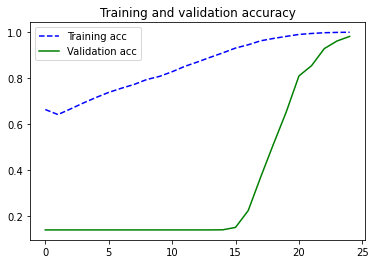

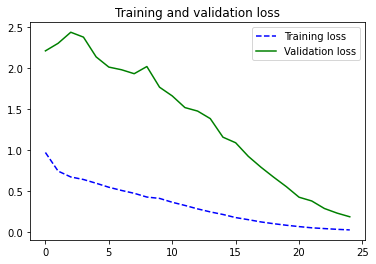

In [31]:
def plot_training_analysis():
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(loss))

    plt.plot(epochs, acc, "b", linestyle="--", label="Training acc")
    plt.plot(epochs, val_acc, "g", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "b", linestyle="--", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()


plot_training_analysis()
